CNN Architecture

1. Input Layer: 28x28 grayscale image
2. First CNN Layer: 2 neurons with kernel size 3x3, stride 1, and Sigmoid activation (Other activations like ReLu and Tanh)
3. Average Pooling Layer with pool size 2x2 and stride 2
4. Flatten the output from the average pooling layer
5. 1x1 Convolution Layer with 10 output channels
6. Softmax Activation

The dimensions calculations is shown below:

Image (28 x 28) ----> Applying filter of (3 x 3 x 2) with a bias ----> Feature Map (26 x 26 x 2) ----> Applying Sigmoid----> Feature Map (26 x 26 x 2) ----> Average pooling (with height = width = 2, stride = 2) ----> Reduced dimension Image (13 x 13 x 2) ----> Flattenning ----> 338 x 1 -----> Fully Connected layer (with 10 neurons) ----> Ten output (one hot encoded outputs)

In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

2024-05-14 22:37:43.790149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data PreProcessing

In [2]:
# Function to load the dataset and normalize pixel values between 0 and 1
def load_data():
    (images_train, labels_train), (images_test, labels_test) = mnist.load_data()
    images_train = images_train.astype('float32') / 255.0
    images_test = images_test.astype('float32') / 255.0
    return (images_train, labels_train), (images_test, labels_test)


# Function to visualize the image 
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()


Dataset Information:
Shape of Training Data: (60000, 28, 28)
Shape of Training Labels: (60000, 1)
Shape of Test Data: (10000, 28, 28)
Shape of Test Labels: (10000, 1)
Shape of Each Image:  (28, 28)


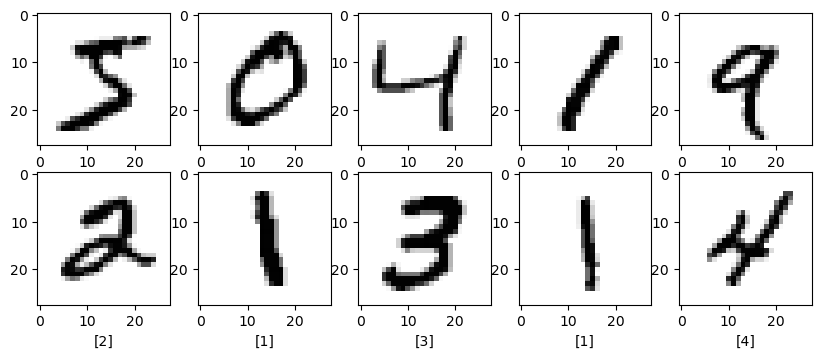

In [3]:
# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = load_data()

#Reshaping to numpy
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("\nDataset Information:")
print("Shape of Training Data:", X_train.shape)
print("Shape of Training Labels:", y_train.shape)
print("Shape of Test Data:", X_test.shape)
print("Shape of Test Labels:", y_test.shape)
print("Shape of Each Image: ", X_test[0].shape)

display_images(X_train, y_train, 10)

In [4]:
# Function to one hot encode the label
def one_hot_encode(y):
    
    n_classes = 10  
    
    y_encoded = np.zeros((len(y), n_classes))
    
    for i, label in enumerate(y):
        y_encoded[i, label] = 1
        
    return y_encoded
    
# Hot Encoding the labels
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print ("Dataset Information after Hot Encoded:")
print("Shape of Training Data:", X_train.shape)
print("Shape of Training Labels:", y_train.shape)
print("Shape of Test Data:", X_test.shape)
print("Shape of Test Labels:", y_test.shape)
print("Shape of Each Image: ", X_test[0].shape)

Dataset Information after Hot Encoded:
Shape of Training Data: (60000, 28, 28)
Shape of Training Labels: (60000, 10)
Shape of Test Data: (10000, 28, 28)
Shape of Test Labels: (10000, 10)
Shape of Each Image:  (28, 28)


# Convolutional Layer

In [5]:
# Implementation of the convolution Layer

# For forward propagation: 
# Two kernels: 3 x 3 with a bias  ----> 26 x 26 x 2 Feature Maps

class ConvolutionLayer:
    def __init__(self, num_kernels=2, kernel_size=3):
        # Initialize the convolutional layer with the number of kernels and kernel size
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        
        self.prev_input = None  # Initialize previous input matrix as None
        self.kernels = np.random.randn(num_kernels, kernel_size, kernel_size)  # Initialize kernels with random values

    def convolve(self, input_matrix, kernel):
        # Perform convolution operation between input matrix and kernel
        kernel_height, kernel_width = kernel.shape
        output_height = input_matrix.shape[0] - kernel_height + 1
        output_width = input_matrix.shape[1] - kernel_width + 1
        
        output_matrix = np.zeros((output_height, output_width))
        
        for i in range(output_height):
            for j in range(output_width):
                output_matrix[i, j] = np.sum(input_matrix[i:i+kernel_height, j:j+kernel_width] * kernel)
                
        return output_matrix

    def forward_propagation(self, input_matrix):
        # Perform forward propagation for the convolutional layer
        
        self.prev_input = input_matrix  # Remember the input matrix for backpropagation
        
        output_height = input_matrix.shape[0] - self.kernel_size + 1
        output_width = input_matrix.shape[1] - self.kernel_size + 1
        
        convolution_output = np.zeros((output_height, output_width, self.num_kernels))
        
        for i in range(self.num_kernels):
            convolved = self.convolve(input_matrix, self.kernels[i])
            
            for hi in range(output_height):
                for wi in range(output_width):
                    convolution_output[hi, wi, i] = convolved[hi, wi]
                    
        return convolution_output

    def backward_propagation(self, d_output, learning_rate):
        # Perform backward propagation for the convolutional layer
        
        d_kernels = np.zeros(self.kernels.shape)
        
        for i in range(self.num_kernels):
            d_kernels[i] = self.convolve(self.prev_input, d_output[:, :, i])

        self.kernels -= learning_rate * d_kernels  # Update kernels based on learning rate and gradients
        
        return None


In [6]:
#Display Feature Map
def display_feature_map(feature_maps, num_maps = 2):

    num_columns = num_maps
    num_rows = 1

    plt.figure(figsize=(num_columns * 2, num_rows * 2))

    for i in range(num_maps):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(feature_maps[:, :, i], cmap='gray')
        plt.xlabel(f'Filter {i+1}')

    plt.show()

# Average Pooling Layer

In [7]:
# Implementation of Average Pooling layer

# For forward propagation:
# Input : Feature Map (26 x 26 x 2)
# Average pool (size 2 x 2, stride = 2)

# Output dimension: (n - f + 2 * padding)/stride + 1 = 13 x 13 x 2 (Since there is no padding)

class AveragePoolingLayer:
    def __init__(self, pool_size=2):
        # Initialize the average pooling layer with the pool size
        self.pool_size = pool_size
        self.prev_input = None  # Initialize previous input matrix as None

    def forward_propagation(self, input_matrix):
        # Perform forward propagation for average pooling
        
        # Remember the input matrix for use in backpropagation
        self.prev_input = input_matrix
        
        m, n, o = input_matrix.shape
        # Initialize the output matrix
        output_matrix = np.zeros((int(m / self.pool_size), int(n / self.pool_size), o))
        
        # Apply average pooling
        for i in range(0, m, self.pool_size):
            for j in range(0, n, self.pool_size):
                # Take the mean of the pool size
                output_matrix[int(i / self.pool_size), int(j / self.pool_size)] = np.mean(input_matrix[i:i + self.pool_size, j:j + self.pool_size], axis=(0, 1))
        
        return output_matrix

    def backward_propagation(self, d_output):
        # Perform backward propagation for average pooling
        
        # Initialize the output matrix for gradients
        output_matrix = np.zeros(self.prev_input.shape)
        
        for i in range(0, output_matrix.shape[0], self.pool_size):
            for j in range(0, output_matrix.shape[1], self.pool_size):
                for k in range(self.pool_size):
                    for l in range(self.pool_size):
                        
                        # Upscale the gradients
                        output_matrix[i + k, j + l] = d_output[int(i / self.pool_size), int(j / self.pool_size)] / (self.pool_size * self.pool_size)
        
        return output_matrix


# Fully Connected Layer

#### Since the data is `flattened`, the 1 x 1 convolution changes to fully connected layer

In [8]:
# Flattening Layer in the network

# For Forward Propagation:
# Input: 13 x 13 x 2 image from average pooling
# Apply Flattening
# Ouput : Vector of size 338 x 1

# Then, Fully Connected layer (since the data is flattened, the 1 x 1 convolution changes to fully connected layer)

class FullyConnectedLayer:
    def __init__(self, input_neurons, output_neurons):
        
        # Initialize weights for each neuron in the flattened layer using He initialization
        self.weights = np.random.randn(input_neurons, output_neurons) * np.sqrt(2 / input_neurons)
        self.biases = np.zeros(output_neurons)
        
        self.input_shape = None
        self.last_input = None

    def forward_propagation(self, input_layer):
        # Store shape for backpropagation
        self.input_shape = input_layer.shape
        
        input_layer_flat = input_layer.flatten()
        
        self.last_input = input_layer_flat
        
        return np.dot(input_layer_flat, self.weights) + self.biases

    def backward_propagation(self, d_output, learning_rate):
        # d_output is a vector of shape (output_neurons,)
        output_matrix = np.dot(d_output, self.weights.T).reshape(self.input_shape)
        
        d_weights = np.dot(self.last_input.reshape(-1, 1), d_output.reshape(1, -1))
        d_biases = d_output

        # Update weights and biases
        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases
        
        return output_matrix

# Convolutional Neural Network

In [9]:
# This class implements a Convolutional Neural Network (CNN) for image classification tasks. 

# Methods:
# forward: Perform forward propagation through the network.
# backward: Perform backward propagation through the network.
# train: Train the model on the given data.
# test: Evaluate the model on the test data.

class CNN:
    def __init__(self, activation_function='sigmoid'):
        # Initialize layers
        self.conv1 = ConvolutionLayer()
        self.pool1 = AveragePoolingLayer()
        self.fc1 = FullyConnectedLayer(13 * 13 * 2, 10)
        self.last_conv_activation = None
        self.activation_function = None
        self.activation_function_derivative = None

        # Define activation functions based on the given activation_function name
        # (Taken from Assignment 5, Neural Network)
        if activation_function == 'relu':
            self.activation_function = self.relu
            self.activation_function_derivative = self.relu_derivative
            
        elif activation_function == 'sigmoid':
            self.activation_function = self.sigmoid
            self.activation_function_derivative = self.sigmoid_derivative
            
        elif activation_function == 'tanh':
            self.activation_function = self.tanh
            self.activation_function_derivative = self.tanh_derivative

    # Activation functions and their derivatives
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2
        
    # Softmax function for output layer
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x))
        return exp_values / exp_values.sum(axis=-1, keepdims=True)

    # Forward propagation
    def forward(self, input_data):
        
        # Convolutional layer
        layer_result = self.conv1.forward_propagation(input_data)
        self.last_conv_activation = self.activation_function(layer_result)
        
        # Pooling layer
        layer_result = self.pool1.forward_propagation(self.last_conv_activation)
        
        # Fully connected layer
        layer_result = self.fc1.forward_propagation(layer_result)
        
        # Softmax activation for output
        layer_result = self.softmax(layer_result)
        return layer_result

    # Backward propagation
    def backward(self, loss_derivative, learning_rate):
        
        # Backpropagation through fully connected layer
        loss_derivative = self.fc1.backward_propagation(loss_derivative, learning_rate)
        
        # Backpropagation through pooling layer
        loss_derivative = self.pool1.backward_propagation(loss_derivative)
        
        # Backpropagation through activation function of the last convolutional layer
        loss_derivative *= self.activation_function_derivative(self.last_conv_activation)
        
        # Backpropagation through convolutional layer
        self.conv1.backward_propagation(loss_derivative, learning_rate)

    # Training the model
    def train(self, x_train, y_train, x_test, y_test, learning_rate, epochs):
        for epoch in range(epochs):
            loss = 0
            accuracy = 0
            for x, y in zip(x_train, y_train):
                
                # Forward pass
                y_pred = self.forward(x)
                
                # Categorical cross-entropy loss
                loss += -np.sum(y * np.log(y_pred))
                
                # Accuracy calculation
                accuracy += np.argmax(y_pred) == np.argmax(y)
                
                # Calculate loss derivative
                loss_derivative = y_pred - y
                
                # Backward pass
                self.backward(loss_derivative, learning_rate)
                
            # Calculate average loss and accuracy for the epoch
            loss /= len(x_train)
            accuracy /= len(x_train)
            
            print(f'Epoch: {epoch + 1}, Train: Loss: {loss:.4f}, Accuracy: {accuracy:.4f} |', end=" ")
            
            # Test the model on test data
            self.test(x_test, y_test)

    # Test the model
    def test(self, x_test, y_test):
        loss = 0
        accuracy = 0
        n = len(x_test)
        
        for x, y in zip(x_test, y_test):
            
            # Forward pass
            y_pred = self.forward(x)
            
            # Categorical cross-entropy loss
            loss += -np.sum(y * np.log(y_pred))
            
            # Accuracy calculation
            accuracy += np.argmax(y_pred) == np.argmax(y)
            
        # Calculate average loss and accuracy for the test set
        loss /= n
        accuracy /= n
        
        print(f'Test: Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


# Training and Testing Neural Network with different Activation Functions

#### Sigmoid Activation Function

In [10]:
cnn = CNN()

cnn.train(X_train, y_train, X_test, y_test, learning_rate = 0.005, epochs = 6)

Epoch: 1, Train: Loss: 0.5667, Accuracy: 0.8455 | Test: Loss: 0.4381, Accuracy: 0.8602
Epoch: 2, Train: Loss: 0.3947, Accuracy: 0.8838 | Test: Loss: 0.3980, Accuracy: 0.8757
Epoch: 3, Train: Loss: 0.3716, Accuracy: 0.8888 | Test: Loss: 0.3812, Accuracy: 0.8807
Epoch: 4, Train: Loss: 0.3601, Accuracy: 0.8921 | Test: Loss: 0.3716, Accuracy: 0.8843
Epoch: 5, Train: Loss: 0.3529, Accuracy: 0.8946 | Test: Loss: 0.3653, Accuracy: 0.8867
Epoch: 6, Train: Loss: 0.3479, Accuracy: 0.8961 | Test: Loss: 0.3608, Accuracy: 0.8880


#### ReLu Activation Function

In [11]:
cnn1 = CNN(activation_function = 'relu')

cnn1.train(X_train, y_train, X_test, y_test, learning_rate = 0.005, epochs = 6)

Epoch: 1, Train: Loss: 0.3661, Accuracy: 0.8931 | Test: Loss: 0.3102, Accuracy: 0.9064
Epoch: 2, Train: Loss: 0.2911, Accuracy: 0.9176 | Test: Loss: 0.2856, Accuracy: 0.9143
Epoch: 3, Train: Loss: 0.2457, Accuracy: 0.9303 | Test: Loss: 0.2078, Accuracy: 0.9384
Epoch: 4, Train: Loss: 0.1823, Accuracy: 0.9469 | Test: Loss: 0.1637, Accuracy: 0.9517
Epoch: 5, Train: Loss: 0.1557, Accuracy: 0.9547 | Test: Loss: 0.1485, Accuracy: 0.9554
Epoch: 6, Train: Loss: 0.1437, Accuracy: 0.9577 | Test: Loss: 0.1404, Accuracy: 0.9579


#### Tanh Activation Function

In [12]:
cnn2 = CNN(activation_function = 'tanh')

cnn2.train(X_train, y_train, X_test, y_test, learning_rate = 0.005, epochs = 6)

Epoch: 1, Train: Loss: 0.4431, Accuracy: 0.8698 | Test: Loss: 0.4130, Accuracy: 0.8697
Epoch: 2, Train: Loss: 0.3667, Accuracy: 0.8896 | Test: Loss: 0.3918, Accuracy: 0.8788
Epoch: 3, Train: Loss: 0.3561, Accuracy: 0.8925 | Test: Loss: 0.3833, Accuracy: 0.8819
Epoch: 4, Train: Loss: 0.3508, Accuracy: 0.8943 | Test: Loss: 0.3791, Accuracy: 0.8835
Epoch: 5, Train: Loss: 0.3474, Accuracy: 0.8953 | Test: Loss: 0.3767, Accuracy: 0.8847
Epoch: 6, Train: Loss: 0.3449, Accuracy: 0.8963 | Test: Loss: 0.3752, Accuracy: 0.8852


# Some References

1. https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
2. https://nordinzakaria.medium.com/backpropagation-in-cnn-a-mathematically-explicit-exposition-3f723f0ad9a0
3. https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c
4. https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509

Shape after convolution layer: (26, 26, 2)
After convolution layer:


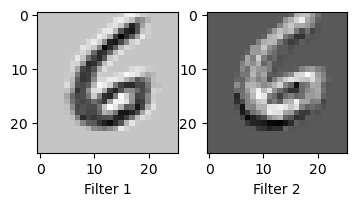

Shape after convolution layer: (13, 13, 2)
After average pooling  layer:


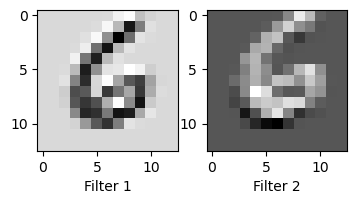

In [14]:
# To check how the outputs are like after different layers

conv_layer = ConvolutionLayer(num_kernels=2, kernel_size=3) 
output = conv_layer.forward_propagation(X_train[90])  # Forward pass
print("Shape after convolution layer:", output.shape)
print ("After convolution layer:")
display_feature_map(output, num_maps=2)



pool_layer = AveragePoolingLayer()
output1 = pool_layer.forward_propagation(output)
print ("Shape after convolution layer:", output1.shape)
print ("After average pooling  layer:")
display_feature_map(output1, num_maps=2)